In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
from attlike.utils import load_data, LikelihoodMode
from pathlib import Path
from datasets import DatasetDict
from pathlib import Path
import numpy as np
from nn_core.common import PROJECT_ROOT

2023-04-14 17:20:59 INFO     Created a temporary directory at              ]8;id=73227;file:///home/valentino/miniconda3/envs/attlike/lib/python3.10/site-packages/torch/distributed/nn/jit/instantiator.py\torch.distributed.nn.jit.instantiator]8;;\:]8;id=255017;file:///home/valentino/miniconda3/envs/attlike/lib/python3.10/site-packages/torch/distributed/nn/jit/instantiator.py#21\21]8;;\
                             /tmp/tmp400xhr4f                                                                      

                    INFO     Writing                                       ]8;id=860361;file:///home/valentino/miniconda3/envs/attlike/lib/python3.10/site-packages/torch/distributed/nn/jit/instantiator.py\torch.distributed.nn.jit.instantiator]8;;\:]8;id=48779;file:///home/valentino/miniconda3/envs/attlike/lib/python3.10/site-packages/torch/distributed/nn/jit/instantiator.py#76\76]8;;\
                             /tmp/tmp400xhr4f/_remote_module_non_scriptabl                                         
                             e.py                                                                                  

In [3]:
DATA_DIR: Path = PROJECT_ROOT / "data"

In [4]:
likelihood2encoder2data = DatasetDict(
    {
        likelihood_path.name: DatasetDict.load_from_disk(likelihood_path)
        for likelihood_path in (DATA_DIR / "likelihoods").iterdir()
        if not likelihood_path.name.endswith(".json")
    }
)
likelihood2encoder2data.keys()

dict_keys(['low', 'lowest', 'high', 'real', 'highest', 'mid'])

In [5]:
likelihood_mode1 = "real"
likelihood_mode2 = LikelihoodMode.LOWEST
encoder: str = "roberta-base"
n: int = 10

for i, (sample1, sample2) in enumerate(
    zip(
        likelihood2encoder2data[likelihood_mode1][encoder],
        likelihood2encoder2data[likelihood_mode2][encoder],
    )
):
    if sample1["lemma"].strip() != sample2["lemma"].strip():
        print(f"Sentence: {sample1['sentence']} | {sample1['lemma']} - {sample2['lemma'].strip()}")

    if i >= n:
        break

Sentence: she was able to program her computer | able - Drop
Sentence: we were at last able to buy a car | able - physical
Sentence: able to get a grant for the project | able - protr
Sentence: unable to get to town without a car | unable - MIC Hau
Sentence: the abaxial surface of a leaf is the underside or side facing away from the stem | abaxial - KS IdleWeapons
Sentence: the upper side of a leaf is known as the adaxial surface | adaxial - OSH RankedIGHTS
Sentence: a potted version of a novel | potted - Alias GEAR
Sentence: she is a living doll | living - headers
Sentence: scared the living daylights out of them | living - operator
Sentence: beat the living hell out of him | living - Modes
Sentence: as absorbent as a sponge | absorbent - Flying Swordsman


In [6]:
from torchmetrics.functional import spearman_corrcoef as corrcoef

correlation_df = {
    "likelihood_mode": [],
    "inner_likelihood": [],
    "attention": [],
    "inner_attention": [],
    "outer_attention": [],
    "encoder": [],
    "layer": [],
    "correlation": [],
    "inner_likelihood_std": [],
    "attention_std": [],
    "inner_attention_std": [],
    "outer_attention_std": [],
}

for likelihood, encoder2data in list(likelihood2encoder2data.items()):
    x = []
    for encoder_name, encoder_data in list(encoder2data.items()):
        for layer in range(50):
            if f"inner_attention_{layer}_mean" not in encoder_data.column_names:
                continue
            correlation_df["likelihood_mode"].append(likelihood)
            correlation_df["inner_likelihood"].append(encoder_data["inner_likelihoods_mean"].mean().item())
            correlation_df["inner_likelihood_std"].append(encoder_data["inner_likelihoods_mean"].std().item())
            correlation_df["inner_attention"].append(encoder_data[f"inner_attention_{layer}_mean"].mean().item())
            correlation_df["inner_attention_std"].append(encoder_data[f"inner_attention_{layer}_mean"].std().item())
            correlation_df["outer_attention"].append(encoder_data[f"outer_attention_{layer}_mean"].mean().item())
            correlation_df["outer_attention_std"].append(encoder_data[f"outer_attention_{layer}_mean"].std().item())
            correlation_df["attention"].append(encoder_data[f"attention_{layer}_mean"].mean().item())
            correlation_df["attention_std"].append(encoder_data[f"attention_{layer}_mean"].std().item())
            correlation_df["encoder"].append(encoder_name)
            correlation_df["layer"].append(layer)
            correlation = corrcoef(
                encoder_data["inner_likelihoods_mean"].squeeze(-1),
                encoder_data[f"inner_attention_{layer}_mean"].squeeze(-1),
            ).item()
            correlation_df["correlation"].append(correlation)
correlation_df = pd.DataFrame(correlation_df)

In [7]:
idx = (
    correlation_df.groupby(["encoder",])[
        "correlation"
    ].transform(max)
    == correlation_df["correlation"]
)
correlation_df[idx][["encoder", "layer", "correlation", "inner_likelihood"]]

,encoder,layer,correlation,inner_likelihood
75,bert-base-uncased,9,0.642901,0.095786
130,distilbert-base-uncased,4,0.687584,0.016773
155,roberta-base,11,0.801689,0.072483
191,roberta-large,23,0.822567,0.054967
365,xlm-roberta-base,11,0.766631,0.017382


In [8]:
real_likelihoods = (
    correlation_df[correlation_df.likelihood_mode == "real"]
    .groupby("encoder")["inner_likelihood"]
    .aggregate(["max"])
    .to_dict()["max"]
)
real_likelihoods

{'bert-base-uncased': 0.663658618927002,
 'distilbert-base-uncased': 0.7850713133811951,
 'roberta-base': 0.9384443163871765,
 'roberta-large': 0.947394609451294,
 'xlm-roberta-base': 0.9425700306892395}

In [9]:
correlation_df["inner_likelihood_real"] = correlation_df["encoder"].map(real_likelihoods)
correlation_df.head()

,likelihood_mode,inner_likelihood,attention,inner_attention,outer_attention,encoder,layer,correlation,inner_likelihood_std,attention_std,inner_attention_std,outer_attention_std,inner_likelihood_real
0,low,0.14524,0.09881,0.113051,0.098257,bert-base-uncased,0,0.003345,0.24419,0.025692,0.034307,0.025969,0.663659
1,low,0.14524,0.09881,0.053262,0.100248,bert-base-uncased,1,0.037827,0.24419,0.025692,0.019007,0.026191,0.663659
2,low,0.14524,0.09881,0.084208,0.099141,bert-base-uncased,2,0.448137,0.24419,0.025692,0.025533,0.026237,0.663659
3,low,0.14524,0.09881,0.054403,0.099830,bert-base-uncased,3,0.256296,0.24419,0.025692,0.023566,0.026345,0.663659
4,low,0.14524,0.09881,0.064569,0.099763,bert-base-uncased,4,0.084421,0.24419,0.025692,0.021179,0.026200,0.663659


In [10]:
lower_likelihood_df = correlation_df[correlation_df.inner_likelihood < correlation_df.inner_likelihood_real]
len(lower_likelihood_df)

264

In [11]:
max_idx = (
    lower_likelihood_df.groupby(["encoder",])[
        "correlation"
    ].transform(max)
    == lower_likelihood_df["correlation"]
)
min_idx = (
    lower_likelihood_df.groupby(["encoder",])[
        "correlation"
    ].transform(min)
    == lower_likelihood_df["correlation"]
)

max_lower_likelihood_df = lower_likelihood_df[max_idx].copy()
max_lower_likelihood_df["target_correlation"] = "max"

min_lower_likelihood_df = lower_likelihood_df[min_idx].copy()
min_lower_likelihood_df["target_correlation"] = "min"

# perturbed_df = pd.concat([max_lower_likelihood_df, min_lower_likelihood_df])
perturbed_df = max_lower_likelihood_df
perturbed_df = perturbed_df[perturbed_df.encoder != "albert-base-v2"]
perturbed_df = perturbed_df[
    [
        "encoder",
        # "target_correlation",
        "layer",
        "attention",
        "attention_std",
        "inner_attention",
        "inner_attention_std",
        "outer_attention",
        "outer_attention_std",
        "inner_likelihood",
        "inner_likelihood_std",
        "correlation",
        "likelihood_mode",
    ]
]
perturbed_df.head()

,encoder,layer,attention,attention_std,inner_attention,inner_attention_std,outer_attention,outer_attention_std,inner_likelihood,inner_likelihood_std,correlation,likelihood_mode
75,bert-base-uncased,9,0.098810,0.025692,0.062833,0.041480,0.099721,0.026314,0.095786,0.197539,0.642901,lowest
130,distilbert-base-uncased,4,0.098810,0.025692,0.045426,0.035298,0.099993,0.026461,0.016773,0.068814,0.687584,lowest
155,roberta-base,11,0.099556,0.024887,0.042647,0.032833,0.100869,0.025637,0.072483,0.173935,0.801689,high
191,roberta-large,23,0.099556,0.024887,0.046074,0.035148,0.100755,0.025544,0.054967,0.149300,0.822567,high
365,xlm-roberta-base,11,0.089392,0.023990,0.050840,0.033801,0.090406,0.024606,0.017382,0.070976,0.766631,mid


In [12]:
real_df = correlation_df[(correlation_df["likelihood_mode"] == "real")]
real_df = real_df[
    [
        "encoder",
        # "target_correlation",
        "layer",
        "attention",
        "attention_std",
        "inner_attention",
        "inner_attention_std",
        "outer_attention",
        "outer_attention_std",
        "inner_likelihood",
        "inner_likelihood_std",
        "correlation",
        "likelihood_mode",
    ]
]

In [13]:
coupled_columns = [
    (col, f"{col}_std")
    for col in perturbed_df.columns
    if f"{col}_std" in perturbed_df.columns  # and "likelihood" in col
]

# # round the values
# for col in perturbed_df.columns:
#     # check if the column is a float
#     if perturbed_df[col].dtype == float:
#         perturbed_df[col] = perturbed_df[col].apply(lambda x: np.round(x, 3))
#         real_df[col] = real_df[col].apply(lambda x: np.round(x, 3))
#         # pad the column with zeros
#         perturbed_df[col] = perturbed_df[col].apply(lambda x: f"{x:0.3f}")
#         real_df[col] = real_df[col].apply(lambda x: f"{x:0.3f}")

# # add the standard deviation to the value
# for metric_col, std_col in coupled_columns:
#     perturbed_df[metric_col] = [
#         f"{x} ± {y}" for x, y in zip(perturbed_df[metric_col], perturbed_df[std_col])
#     ]
#     real_df[metric_col] = [
#         f"{x} ± {y}" for x, y in zip(real_df[metric_col], real_df[std_col])
#     ]

#     del perturbed_df[std_col]
#     del real_df[std_col]

real_df.to_csv(DATA_DIR / "real_df.tsv", sep="\t", index=False)
perturbed_df.to_csv(DATA_DIR / "perturbed_df.tsv", sep="\t", index=False)

full_df = pd.merge(
    left=real_df,
    right=perturbed_df,
    on=["encoder", "layer"],
    suffixes=["_real", "_perturbed"],
)
full_df.to_csv(DATA_DIR / "full_df.tsv", sep="\t", index=False)
full_df.head()

,encoder,layer,attention_real,attention_std_real,inner_attention_real,inner_attention_std_real,outer_attention_real,outer_attention_std_real,inner_likelihood_real,inner_likelihood_std_real,...,attention_perturbed,attention_std_perturbed,inner_attention_perturbed,inner_attention_std_perturbed,outer_attention_perturbed,outer_attention_std_perturbed,inner_likelihood_perturbed,inner_likelihood_std_perturbed,correlation_perturbed,likelihood_mode_perturbed
0,bert-base-uncased,9,0.098810,0.025692,0.074987,0.032488,0.099916,0.026053,0.663659,0.356065,...,0.098810,0.025692,0.062833,0.041480,0.099721,0.026314,0.095786,0.197539,0.642901,lowest
1,roberta-base,11,0.099556,0.024887,0.124329,0.047694,0.099334,0.025083,0.938444,0.197165,...,0.099556,0.024887,0.042647,0.032833,0.100869,0.025637,0.072483,0.173935,0.801689,high
2,xlm-roberta-base,11,0.089392,0.023990,0.131850,0.062842,0.088980,0.024026,0.942570,0.175600,...,0.089392,0.023990,0.050840,0.033801,0.090406,0.024606,0.017382,0.070976,0.766631,mid
3,roberta-large,23,0.099556,0.024887,0.133954,0.040175,0.099075,0.025067,0.947395,0.171740,...,0.099556,0.024887,0.046074,0.035148,0.100755,0.025544,0.054967,0.149300,0.822567,high
4,distilbert-base-uncased,4,0.098810,0.025692,0.064540,0.022500,0.100178,0.026117,0.785071,0.292972,...,0.098810,0.025692,0.045426,0.035298,0.099993,0.026461,0.016773,0.068814,0.687584,lowest


In [14]:
table_keys = list(zip(full_df.encoder, full_df.layer, full_df.likelihood_mode_perturbed))
table_keys

[('bert-base-uncased', 9, 'lowest'),
 ('roberta-base', 11, 'high'),
 ('xlm-roberta-base', 11, 'mid'),
 ('roberta-large', 23, 'high'),
 ('distilbert-base-uncased', 4, 'lowest')]

In [15]:
encoders, _, likelihood_modes = list(zip(*table_keys))
encoder2likelihood = list(zip(encoders, likelihood_modes))
plot_df = correlation_df[correlation_df[["encoder", "likelihood_mode"]].apply(tuple, axis=1).isin(encoder2likelihood)]

plot_df.to_csv(DATA_DIR / "plot_df.tsv", sep="\t", index=False)

In [16]:
import plotly.express as px

In [17]:
import matplotlib.pyplot as plt
from tueplots import figsizes
import matplotlib.cm as cm

In [18]:
plt.rcParams.update(figsizes.iclr2023(ncols=1, nrows=1, height_to_width_ratio=1))
plt.rcParams["text.usetex"] = True

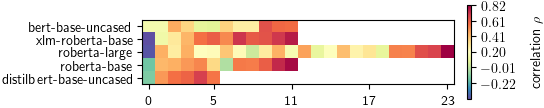

In [19]:
encoders, _, likelihood_modes = list(zip(*table_keys))
encoder2likelihood = list(zip(encoders, likelihood_modes))
plot_df = correlation_df[correlation_df[["encoder", "likelihood_mode"]].apply(tuple, axis=1).isin(encoder2likelihood)]
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True, squeeze=True)


encoder2index = {encoder: i for i, encoder in enumerate(set(plot_df.encoder))}
# populate the matrix
z = np.zeros((len(set(plot_df.encoder)), len(set(plot_df.layer))))
for i, row in plot_df.iterrows():
    z[encoder2index[row.encoder], row.layer] = row.correlation
z = np.ma.masked_where(z == 0, z)

layers = [0, 5, 11, 17, 23]

plt.xticks(labels=[str(a) for a in layers], ticks=layers)
plt.yticks(labels=list(encoder2index.keys()), ticks=list(encoder2index.values()))


image = ax.imshow(
    z,
    cmap="Spectral_r",
    origin="lower",
    # vmin=z.min(),
    # vmax=z.max(),
)

cbar_ticks = np.linspace(z.min(), z.max(), 7)
# ax.tick_params(axis="both", labelsize=4)
cbar = fig.colorbar(
    image,
    ax=ax,
    ticks=[np.round(tick, 2) for tick in cbar_ticks],
    fraction=0.015,
    pad=0.04,
)
cbar.ax.set_ylabel("correlation $\\rho$", rotation=90, labelpad=10)

plt.show()

In [20]:
fig.savefig(DATA_DIR / "correlation.svg", bbox_inches="tight")
!rsvg-convert -f pdf -o $DATA_DIR/correlation.pdf $DATA_DIR/correlation.svg
!rm $DATA_DIR/correlation.svg

In [21]:
data = likelihood2encoder2data["real"]["roberta-base"]
lemma_lengths = torch.as_tensor([x.shape[0] for x in data["lemma_ids"]])
sentence_lengths = torch.as_tensor([x.shape[0] for x in data["sentence_ids"]])

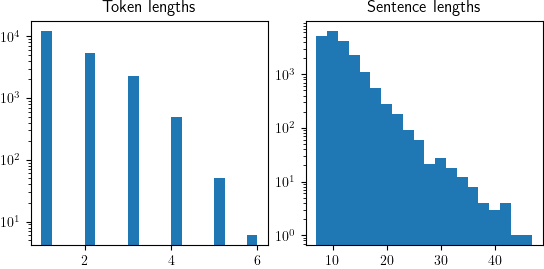

In [22]:
plt.rcParams.update(figsizes.iclr2023(ncols=2, nrows=1, height_to_width_ratio=1))
"""Plot the token and sentence lengths."""
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, squeeze=True)
axs[0].hist(lemma_lengths, bins=20, log=True)
axs[0].set_title("Token lengths")
axs[1].hist(sentence_lengths, bins=20, log=True)
axs[1].set_title("Sentence lengths")
plt.show()

In [23]:
fig.savefig(DATA_DIR / "dataset.svg", bbox_inches="tight")
!rsvg-convert -f pdf -o $DATA_DIR/dataset.pdf $DATA_DIR/dataset.svg
!rm $DATA_DIR/dataset.svg

In [24]:
from scipy.stats import mannwhitneyu

"""Compute the Mann-Whitney U test for the attention distributions."""
for encoder, layer, likelihood_mode in table_keys:
    perturbed_data = likelihood2encoder2data[likelihood_mode][encoder]
    real_data = likelihood2encoder2data["real"][encoder]

    perturbed_attention = [attention[layer, :, :] for attention in perturbed_data["attention"]]
    real_attention = [attention[layer, :, :] for attention in real_data["attention"]]

    start_lemmas = real_data["start_lemma_index"]
    end_lemmas = real_data["end_lemma_index"]

    outer_orig_attention = [
        torch.cat(
            [
                x[start_lemma:end_lemma, :start_lemma],
                x[start_lemma:end_lemma, end_lemma:],
            ],
            dim=1,
        ).mean(dim=0)
        for x, start_lemma, end_lemma in zip(real_attention, start_lemmas, end_lemmas)
    ]
    outer_perturbed_attention = [
        torch.cat(
            [
                x[start_lemma:end_lemma, :start_lemma],
                x[start_lemma:end_lemma, end_lemma:],
            ],
            dim=1,
        ).mean(dim=0)
        for x, start_lemma, end_lemma in zip(perturbed_attention, start_lemmas, end_lemmas)
    ]

    mwu_u1 = []
    mwu_u2 = []
    mwu_p = []
    for x, y in zip(outer_orig_attention, outer_perturbed_attention):
        u1, p = mannwhitneyu(x, y, method="auto")
        u2 = x.shape[0] * y.shape[0] - u1
        mwu_u1.append(u1)
        mwu_u2.append(u2)
        mwu_p.append(p)
    mwu_u1 = torch.as_tensor(mwu_u1)
    mwu_u2 = torch.as_tensor(mwu_u2)
    mwu_p = torch.as_tensor(mwu_p)

    mwu_u1 = mwu_u1.mean().item()
    mwu_u2 = mwu_u2.mean().item()
    mwu_p = mwu_p.mean().item()

    diff_mean = (
        torch.stack(
            [
                (x - y)[start_lemma:end_lemma, :].mean(dim=1).mean()
                for x, y, start_lemma, end_lemma in zip(perturbed_attention, real_attention, start_lemmas, end_lemmas)
            ]
        )
        .mean()
        .item()
    )
    diff_std = (
        torch.stack(
            [
                (x - y)[start_lemma:end_lemma, :].std(dim=1).mean()
                for x, y, start_lemma, end_lemma in zip(perturbed_attention, real_attention, start_lemmas, end_lemmas)
            ]
        )
        .mean()
        .item()
    )

    print(f"{encoder} {layer=} {likelihood_mode=} {diff_mean=} {diff_std=} {mwu_u1=} {mwu_u2=} {mwu_p=}")

bert-base-uncased layer=9 likelihood_mode='lowest' diff_mean=-3.920451463468311e-11 diff_std=0.06103307381272316 mwu_u1=51.32635055205047 mwu_u2=47.3386238170347 mwu_p=0.5180216554517054
roberta-base layer=11 likelihood_mode='high' diff_mean=-1.0370344166732437e-10 diff_std=0.05361169949173927 mwu_u1=40.64249802839117 mwu_u2=56.438732255520506 mwu_p=0.539919337431387
xlm-roberta-base layer=11 likelihood_mode='mid' diff_mean=-7.057780054831042e-11 diff_std=0.07008374482393265 mwu_u1=48.461750788643535 mwu_u2=71.8762322555205 mwu_p=0.4753928649900121
roberta-large layer=23 likelihood_mode='high' diff_mean=1.282185035228478e-11 diff_std=0.06332818418741226 mwu_u1=42.269420347003155 mwu_u2=54.81180993690852 mwu_p=0.5607710196606683
distilbert-base-uncased layer=4 likelihood_mode='lowest' diff_mean=-2.061697340627333e-11 diff_std=0.05864017456769943 mwu_u1=43.836972594637224 mwu_u2=54.82800177444795 mwu_p=0.5527240156035247


In [25]:
x = []
for likelihood, encoder2data in likelihood2encoder2data.items():
    for encoder_name, encoder_data in encoder2data.items():
        x.append(encoder_data["inner_likelihoods_mean"].mean().item())
    print(likelihood, torch.as_tensor(x).mean().item())
# x

low 0.041193630546331406
lowest 0.032791584730148315
high 0.06694696843624115
real 0.2640671730041504
highest 0.399607390165329
mid 0.3457651734352112


In [26]:
from attlike.utils import data_to_df

In [27]:
likelihood2df = {}
for likelihood, encoder2data in likelihood2encoder2data.items():
    likelihood2df[likelihood] = data_to_df(encoder2data)
likelihood2df.keys()

dict_keys(['low', 'lowest', 'high', 'real', 'highest', 'mid'])

In [28]:
(DATA_DIR / "likelihood_df").mkdir(exist_ok=True)
for likelihood, df in likelihood2df.items():
    df.to_csv(DATA_DIR / "likelihood_df" / f"{likelihood}.tsv", sep="\t", index=False)

In [29]:
likelihood2df = {
    likelihood_file.name.split(".")[0]: pd.read_csv(likelihood_file, sep="\t")
    for likelihood_file in (DATA_DIR / "likelihood_df").iterdir()
    if likelihood_file.name.endswith(".tsv")
}
likelihood2df = {likelihood: df for likelihood, df in likelihood2df.items()}
likelihood2df.keys()

dict_keys(['high', 'real', 'highest', 'lowest', 'mid', 'low'])

In [30]:
dfs = []
for likelihood, df in likelihood2df.items():
    df["likelihood_mode"] = likelihood
    dfs.append(df)
df = pd.concat(dfs)
df

,encoder,layer,attention,inner_attention,outer_attention,likelihood,likelihood_mode
0,bert-base-uncased,0,0.111111,0.117414,0.111032,2.304286e-03,high
1,bert-base-uncased,0,0.090909,0.126819,0.090610,4.574996e-04,high
2,bert-base-uncased,0,0.100000,0.127791,0.099719,7.362875e-04,high
3,bert-base-uncased,0,0.100000,0.140764,0.099588,9.825145e-02,high
4,bert-base-uncased,0,0.050000,0.076755,0.049384,5.335055e-01,high
...,...,...,...,...,...,...,...
1339003,distilbert-base-uncased,5,0.066667,0.055004,0.067153,6.818367e-03,low
1339004,distilbert-base-uncased,5,0.058824,0.020183,0.058958,1.478052e-06,low
1339005,distilbert-base-uncased,5,0.083333,0.037906,0.084631,5.705641e-07,low
1339006,distilbert-base-uncased,5,0.083333,0.039549,0.084584,6.903951e-06,low


In [31]:
import numpy as np

df.groupby(["likelihood_mode", "layer"]).aggregate([np.mean, np.std])

/tmp/ipykernel_59302/3104618255.py:3: FutureWarning: ['encoder'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby(["likelihood_mode", "layer"]).aggregate([np.mean, np.std])


attention           inner_attention            \
                           mean       std            mean       std   
likelihood_mode layer                                                 
high            0      0.097225  0.025344        0.147253  0.064885   
                1      0.097225  0.025344        0.064847  0.033396   
                2      0.097225  0.025344        0.055197  0.026383   
                3      0.097225  0.025344        0.047934  0.026449   
                4      0.097225  0.025344        0.053746  0.022739   
...                         ...       ...             ...       ...   
real            19     0.099556  0.024887        0.045265  0.013375   
                20     0.099556  0.024887        0.054505  0.018936   
                21     0.099556  0.024887        0.067770  0.034302   
                22     0.099556  0.024887        0.051660  0.029507   
                23     0.099556  0.024887        0.133954  0.040175   

                      outer_attention           likelihood            
                                 mean       std       mean       std  
likelihood_mode layer                                                 
high            0            0.096165  0.025268   0.135258  0.244015  
                1            0.098084  0.026038   0.135258  0.244015  
                2            0.098424  0.026028   0.135258  0.244015  
                3            0.098482  0.026088   0.135258  0.244015  
                4            0.098434  0.025984   0.135258  0.244015  
...                               ...       ...        ...       ...  
real            19           0.101167  0.025567   0.947395  0.171740  
                20           0.100765  0.025543   0.947395  0.171740  
                21           0.100099  0.025618   0.947395  0.171740  
                22           0.100571  0.025612   0.947395  0.171740  
                23           0.099075  0.025067   0.947395  0.171740  

[144 rows x 8 columns]

In [32]:
import plotly.express as px
import plotly.figure_factory as ff

In [33]:
"""Plot the attention distributions."""
px.histogram(
    real_df,
    x=["attention", "outer_attention", "inner_attention"],
    marginal="box",
    barmode="overlay",
    # facet_row="encoder",
    nbins=500,
    title="Real Attention",
)